In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import numpy as np
# torch imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

In [70]:
# Run this once
from google.colab import drive
drive.mount('/content/gdrive')
# You will have to modify this based on your Google Drive directory structure
folder_path = "/content/gdrive/MyDrive/Colab Notebooks/RideStream/"

# Ha nem létezik, akkor létrehozzuk
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Létrehozva: {folder_path}")
else:
    print(f"A könyvtár már létezik: {folder_path}")

# Átváltás a könyvtárba
%cd "$folder_path"
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
A könyvtár már létezik: /content/gdrive/MyDrive/Colab Notebooks/RideStream/
/content/gdrive/MyDrive/Colab Notebooks/RideStream
/content/gdrive/MyDrive/Colab Notebooks/RideStream


In [71]:
class UTKDataset(Dataset):
    '''
        Inputs:
            dataFrame : Pandas dataFrame
            transform : The transform to apply to the dataset
    '''
    def __init__(self, dataFrame, transform=None):
        # read in the transforms
        self.transform = transform

        # Use the dataFrame to get the pixel values
        data_holder = dataFrame.pixels.apply(lambda x: np.array(x.split(" "),dtype=float))
        arr = np.stack(data_holder)
        arr = arr / 255.0
        arr = arr.astype('float32')
        arr = arr.reshape(arr.shape[0], 48, 48, 1)
        # reshape into 48x48x1
        self.data = arr

        # get the age, gender, and ethnicity label arrays
        self.age_label = np.array(dataFrame.bins[:])        # Note : Changed dataFrame.age to dataFrame.bins with most recent change
        self.gender_label = np.array(dataFrame.gender[:])
        self.eth_label = np.array(dataFrame.ethnicity[:])

    # override the length function
    def __len__(self):
        return len(self.data)

    # override the getitem function
    def __getitem__(self, index):
        # load the data at index and apply transform
        data = self.data[index]
        data = self.transform(data)

        # load the labels into a list and convert to tensors
        labels = torch.tensor((self.age_label[index], self.gender_label[index], self.eth_label[index]))

        # return data labels
        return data, labels

In [72]:
# High level feature extractor network (Adopted VGG type structure)
class highLevelNN(nn.Module):
    def __init__(self):
        super(highLevelNN, self).__init__()
        self.CNN = nn.Sequential(
            # first batch (32)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # second batch (64)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # Third Batch (128)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        out = self.CNN(x)

        return out

# Low level feature extraction module
class lowLevelNN(nn.Module):
    def __init__(self, num_out):
        super(lowLevelNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=2048, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=num_out)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=2, padding=1))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=3, stride=2, padding=1))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x


class TridentNN(nn.Module):
    def __init__(self, num_age, num_gen, num_eth):
        super(TridentNN, self).__init__()
        # Construct the high level neural network
        self.CNN = highLevelNN()
        # Construct the low level neural networks
        self.ageNN = lowLevelNN(num_out=num_age)
        self.genNN = lowLevelNN(num_out=num_gen)
        self.ethNN = lowLevelNN(num_out=num_eth)

    def forward(self, x):
        x = self.CNN(x)
        age = self.ageNN(x)
        gen = self.genNN(x)
        eth = self.ethNN(x)

        return age, gen, eth

In [73]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [74]:
'''
    Function to test the trained model

    Inputs:
      - testloader : PyTorch DataLoader containing the test dataset
      - modle : Trained NeuralNetwork

    Outputs:
      - Prints out test accuracy for gender and ethnicity and loss for age
'''
def test(testloader, model):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  size = len(testloader.dataset)
  # put the moel in evaluation mode so we aren't storing anything in the graph
  model.eval()

  age_acc, gen_acc, eth_acc = 0, 0, 0

  with torch.no_grad():
      for X, y in testloader:
          X = X.to(device)
          age, gen, eth = y[:,0].to(device), y[:,1].to(device), y[:,2].to(device)
          pred = model(X)

          age_acc += (pred[0].argmax(1) == age).type(torch.float).sum().item()
          gen_acc += (pred[1].argmax(1) == gen).type(torch.float).sum().item()
          eth_acc += (pred[2].argmax(1) == eth).type(torch.float).sum().item()

  age_acc /= size
  gen_acc /= size
  eth_acc /= size

  print(f"Age Accuracy : {age_acc*100}%,     Gender Accuracy : {gen_acc*100},    Ethnicity Accuracy : {eth_acc*100}\n")

In [75]:
# Read in the dataframe
file_path = "/content/gdrive/MyDrive/Colab Notebooks/RideStream/age_gender.gz"
dataFrame = pd.read_csv(file_path, compression='gzip')

# Construct age bins
age_bins = [0,3,10,20,30,40,50,60,70,120]
age_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
dataFrame['bins'] = pd.cut(dataFrame.age, bins=age_bins, labels=age_labels)

# Split into training and testing

train_dataFrame, temp_dataFrame = train_test_split(dataFrame, test_size=0.2, random_state=42)
val_dataFrame, test_dataFrame = train_test_split(temp_dataFrame, test_size=0.5, random_state=42)

# get the number of unique classes for each group
class_nums = {'age_num':len(dataFrame['bins'].unique()), 'eth_num':len(dataFrame['ethnicity'].unique()),
              'gen_num':len(dataFrame['gender'].unique())}

# Define train and test transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49,), (0.23,))
])

# Construct the custom pytorch datasets
train_set = UTKDataset(train_dataFrame, transform=transform)
val_set = UTKDataset(val_dataFrame, transform=transform)
test_set = UTKDataset(test_dataFrame, transform=transform)

# Load the datasets into dataloaders
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)
valloader = DataLoader(val_set, batch_size=128, shuffle=False)
testloader = DataLoader(test_set, batch_size=128, shuffle=False)

# Sanity Check
for X, y in trainloader:
    print(f'Shape of training X: {X.shape}')
    print(f'Shape of y: {y.shape}')
    break

Shape of training X: torch.Size([64, 1, 48, 48])
Shape of y: torch.Size([64, 3])


In [76]:
# Configure the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Define the list of hyperparameters
hyperparameters = {'learning_rate':0.001, 'epochs':30}

# Initialize the TridentNN model and put on device
model = TridentNN(class_nums['age_num'], class_nums['gen_num'], class_nums['eth_num'])
model.to(device)

cuda


TridentNN(
  (CNN): highLevelNN(
    (CNN): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): ReLU()
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (9): ReLU()
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (14): ReLU()
    )
  )
  (ageNN): lowLevelNN(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [77]:
'''
  Functions to load and save a PyTorch model
'''
def save_checkpoint(state, epoch):
  print("Saving Checkpoint")
  filename = "tridentNN_epoch"+str(epoch)+".pth.tar"
  torch.save(state,filename)

def load_checkpoint(checkpoint):
  print("Loading Checkpoint")
  model.load_state_dict(checkpoint['state_dict'])
  opt.load_state_dict(checkpoint['optimizer'])


In [78]:
def evaluate_val_loss(model, valloader, age_loss, gen_loss, eth_loss, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in valloader:
            X_val = X_val.to(device)
            age_val, gen_val, eth_val = y_val[:,0].to(device), y_val[:,1].to(device), y_val[:,2].to(device)
            pred_val = model(X_val)
            loss = age_loss(pred_val[0], age_val) + gen_loss(pred_val[1], gen_val) + eth_loss(pred_val[2], eth_val)
            val_loss += loss.item()
    return val_loss / len(valloader)


In [79]:
'''
train the model
'''
# Load hyperparameters
learning_rate = hyperparameters['learning_rate']
num_epoch = hyperparameters['epochs']

# Define loss functions
age_loss = nn.CrossEntropyLoss()
gen_loss = nn.CrossEntropyLoss()
eth_loss = nn.CrossEntropyLoss()

# Define optimizer
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=2, verbose=True)

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

# Init best model saving
best_model_state = None
best_epoch = 0

train_losses = []
val_losses = []

# Train the model
for epoch in range(num_epoch):
  model.train()  # Ensure training mode
  # Construct tqdm loop to keep track of training
  loop = tqdm(enumerate(trainloader), total=len(trainloader), position=0, leave=True)
  age_correct, gen_correct, eth_correct, total = 0,0,0,0

  running_loss = 0.0

  # save the model every 5 epochs
  if epoch % 5 == 0:
    checkpoint = {'state_dict' : model.state_dict(), 'optimizer' : opt.state_dict(),
                  'age_loss' : age_loss, 'gen_loss' : gen_loss, 'eth_loss' : eth_loss}
    save_checkpoint(checkpoint, epoch)

  # Loop through dataLoader
  for _, (X,y) in loop:
    # Unpack y to get true age, eth, and gen values
    # Have to do some special changes to age label to make it compatible with NN output and Loss function
    #age, gen, eth = y[:,0].resize_(len(y[:,0]),1).float().to(device), y[:,1].to(device), y[:,2].to(device)
    age, gen, eth = y[:,0].to(device), y[:,1].to(device), y[:,2].to(device)
    X = X.to(device)
    pred = model(X)          # Forward pass
    loss = age_loss(pred[0],age) + gen_loss(pred[1],gen) + eth_loss(pred[2],eth)   # Loss calculation

    # Backpropagation
    opt.zero_grad()          # Zero the gradient
    loss.backward()          # Calculate updates

    # Gradient Descent
    opt.step()               # Apply updates

    # Update num correct and total
    age_correct += (pred[0].argmax(1) == age).type(torch.float).sum().item()
    gen_correct += (pred[1].argmax(1) == gen).type(torch.float).sum().item()
    eth_correct += (pred[2].argmax(1) == eth).type(torch.float).sum().item()

    total += len(y)

    running_loss += loss.item()

    # Update progress bar
    loop.set_description(f"Epoch [{epoch+1}/{num_epoch}]")
    loop.set_postfix(loss = loss.item())

  # Update epoch accuracy
  gen_acc, eth_acc, age_acc = gen_correct/total, eth_correct/total, age_correct/total

  # print out accuracy and loss for epoch
  print(f'Epoch : {epoch+1}/{num_epoch},    Age Accuracy : {age_acc*100},    Gender Accuracy : {gen_acc*100},    Ethnicity Accuracy : {eth_acc*100}\n')

  epoch_train_loss = running_loss / len(trainloader)

  # Validation loss
  val_loss = evaluate_val_loss(model, valloader, age_loss, gen_loss, eth_loss, device)
  print(f'Train loss: {epoch_train_loss:.4f} Validation loss: {val_loss:.4f}')

  scheduler.step(val_loss)

  for param_group in opt.param_groups:
    print(f"Current learning rate: {param_group['lr']}")

  train_losses.append(epoch_train_loss)
  val_losses.append(val_loss)

  # Early stopping
  if early_stopping.best_loss is None or val_loss < early_stopping.best_loss - early_stopping.min_delta:
      best_model_state = model.state_dict()
      best_epoch = epoch + 1

  early_stopping(val_loss)
  if early_stopping.early_stop:
      print(f"Early stopping activated after {epoch+1}. epoch. Best epoch: {best_epoch}")
      torch.save(best_model_state, '/content/gdrive/MyDrive/UTKFace model/best_model.pt')
      break

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/297 [00:00<?, ?it/s]

Saving Checkpoint


Epoch [1/30]: 100%|██████████| 297/297 [00:08<00:00, 33.49it/s, loss=4.15]


Epoch : 1/30,    Age Accuracy : 34.064543345285806,    Gender Accuracy : 65.24994726850876,    Ethnicity Accuracy : 46.98903184982071

Train loss: 3.8043 Validation loss: 3.2065
Current learning rate: 0.001


Epoch [2/30]: 100%|██████████| 297/297 [00:08<00:00, 33.07it/s, loss=2.67]


Epoch : 2/30,    Age Accuracy : 44.078253533009914,    Gender Accuracy : 81.76545032693524,    Ethnicity Accuracy : 60.983969626661036

Train loss: 2.9260 Validation loss: 2.7379
Current learning rate: 0.001


Epoch [3/30]: 100%|██████████| 297/297 [00:11<00:00, 26.77it/s, loss=2.27]


Epoch : 3/30,    Age Accuracy : 49.071925754060324,    Gender Accuracy : 85.51465935456655,    Ethnicity Accuracy : 70.64965197215777

Train loss: 2.4539 Validation loss: 2.3786
Current learning rate: 0.001


Epoch [4/30]: 100%|██████████| 297/297 [00:08<00:00, 33.26it/s, loss=2.3]


Epoch : 4/30,    Age Accuracy : 52.17253743935879,    Gender Accuracy : 88.01940518877875,    Ethnicity Accuracy : 74.52014342965619

Train loss: 2.2071 Validation loss: 2.1972
Current learning rate: 0.001


Epoch [5/30]: 100%|██████████| 297/297 [00:08<00:00, 33.48it/s, loss=1.93]


Epoch : 5/30,    Age Accuracy : 54.20269985235182,    Gender Accuracy : 89.51170639105675,    Ethnicity Accuracy : 77.59438936933137

Train loss: 2.0213 Validation loss: 2.1323
Current learning rate: 0.001


  0%|          | 0/297 [00:00<?, ?it/s]

Saving Checkpoint


Epoch [6/30]: 100%|██████████| 297/297 [00:09<00:00, 32.37it/s, loss=1.58]


Epoch : 6/30,    Age Accuracy : 56.17485762497364,    Gender Accuracy : 90.43450748787177,    Ethnicity Accuracy : 79.36089432609154

Train loss: 1.8906 Validation loss: 2.0797
Current learning rate: 0.001


Epoch [7/30]: 100%|██████████| 297/297 [00:09<00:00, 30.58it/s, loss=1.89]


Epoch : 7/30,    Age Accuracy : 57.798987555368065,    Gender Accuracy : 91.64733178654292,    Ethnicity Accuracy : 81.2645011600928

Train loss: 1.7751 Validation loss: 2.0825
Current learning rate: 0.001


Epoch [8/30]: 100%|██████████| 297/297 [00:08<00:00, 34.16it/s, loss=1.78]


Epoch : 8/30,    Age Accuracy : 59.19637207340224,    Gender Accuracy : 92.38029951487027,    Ethnicity Accuracy : 82.77789495886944

Train loss: 1.6610 Validation loss: 2.1333
Current learning rate: 0.001


Epoch [9/30]: 100%|██████████| 297/297 [00:08<00:00, 33.94it/s, loss=1.43]


Epoch : 9/30,    Age Accuracy : 60.80995570554736,    Gender Accuracy : 92.96561906770724,    Ethnicity Accuracy : 84.27019616114744

Train loss: 1.5575 Validation loss: 2.0349
Current learning rate: 0.001


Epoch [10/30]: 100%|██████████| 297/297 [00:09<00:00, 31.01it/s, loss=1.73]


Epoch : 10/30,    Age Accuracy : 62.21261337270618,    Gender Accuracy : 94.09934612950855,    Ethnicity Accuracy : 85.88377979329256

Train loss: 1.4509 Validation loss: 2.0910
Current learning rate: 0.001


  0%|          | 0/297 [00:00<?, ?it/s]

Saving Checkpoint


Epoch [11/30]: 100%|██████████| 297/297 [00:09<00:00, 32.07it/s, loss=1.42]


Epoch : 11/30,    Age Accuracy : 64.26386838219786,    Gender Accuracy : 94.63720734022358,    Ethnicity Accuracy : 87.41826618856781

Train loss: 1.3325 Validation loss: 2.2506
Current learning rate: 0.001


Epoch [12/30]: 100%|██████████| 297/297 [00:10<00:00, 29.64it/s, loss=0.739]


Epoch : 12/30,    Age Accuracy : 66.74224847078676,    Gender Accuracy : 95.31217042817971,    Ethnicity Accuracy : 88.44125711875131

Train loss: 1.2303 Validation loss: 2.4324
Current learning rate: 0.0005


Epoch [13/30]: 100%|██████████| 297/297 [00:08<00:00, 33.80it/s, loss=0.705]


Epoch : 13/30,    Age Accuracy : 73.7397173592069,    Gender Accuracy : 97.05758278844125,    Ethnicity Accuracy : 92.91288757646066

Train loss: 0.9033 Validation loss: 2.7394
Current learning rate: 0.0005


Epoch [14/30]: 100%|██████████| 297/297 [00:08<00:00, 33.12it/s, loss=1.04]


Epoch : 14/30,    Age Accuracy : 77.56275047458342,    Gender Accuracy : 97.5216199114111,    Ethnicity Accuracy : 94.47373971735921

Train loss: 0.7605 Validation loss: 2.9587
Current learning rate: 0.0005
Early stopping activated after 14. epoch. Best epoch: 9


In [80]:
# Load the best model
model.load_state_dict(torch.load('/content/gdrive/MyDrive/UTKFace model/best_model.pt'))
model.to(device)
model.eval()


TridentNN(
  (CNN): highLevelNN(
    (CNN): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): ReLU()
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (9): ReLU()
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (14): ReLU()
    )
  )
  (ageNN): lowLevelNN(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

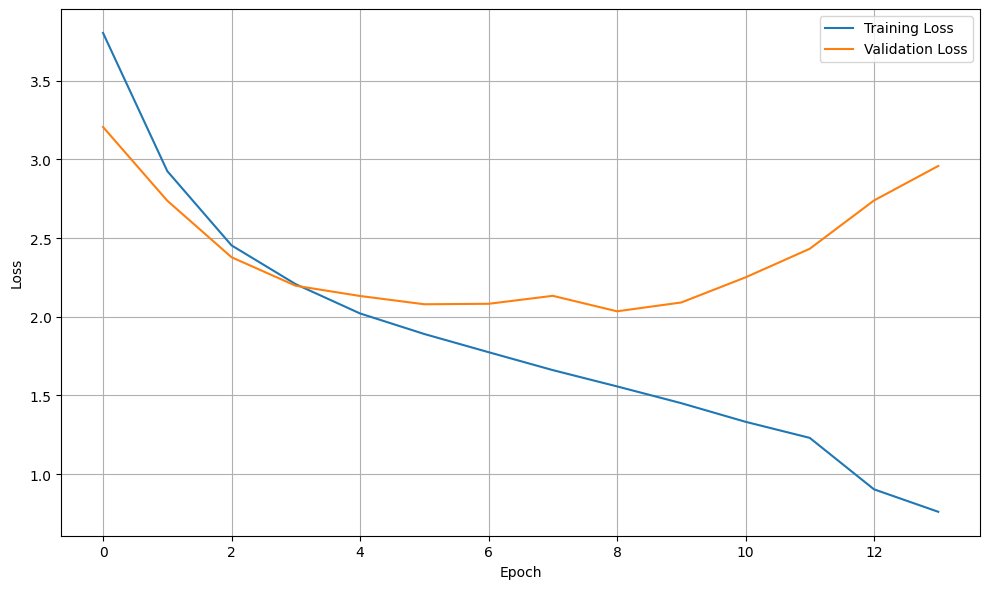

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_curve.png')
plt.show()


In [82]:
test(testloader, model)

Age Accuracy : 53.8169548713623%,     Gender Accuracy : 90.17292281737663,    Ethnicity Accuracy : 77.01391817798398



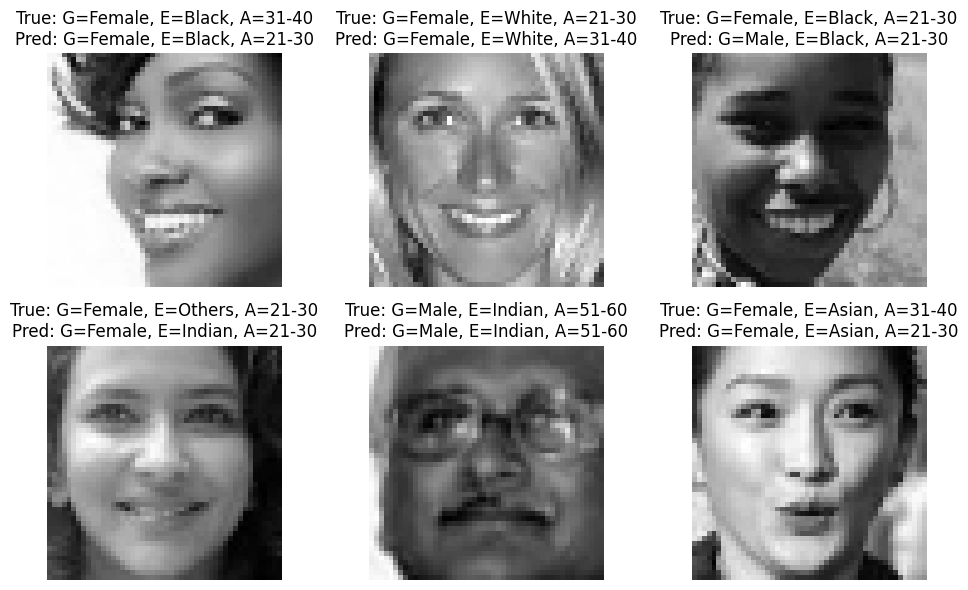

In [83]:
model.eval()

# Visualize the predictions

images, labels = next(iter(testloader))
images = images.to(device)
labels = labels.to(device)

age_labels = labels[:, 0]
gender_labels = labels[:, 1]
ethnicity_labels = labels[:, 2]

with torch.no_grad():
    outputs = model(images)
    age_preds = torch.argmax(outputs[0], dim=1)
    gender_preds = torch.argmax(outputs[1], dim=1)
    ethnicity_preds = torch.argmax(outputs[2], dim=1)

class_names = {
    'gender': ['Male', 'Female'],
    'ethnicity': ['White', 'Black', 'Asian', 'Indian', 'Others'],
    'age': ['0-3', '4-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '70+']
}


num_images = 6
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for i in range(num_images):
    img = images[i].cpu().squeeze().numpy()

    true_gender = class_names['gender'][gender_labels[i].item()]
    true_ethnicity = class_names['ethnicity'][ethnicity_labels[i].item()]
    true_age = class_names['age'][age_labels[i].item()]

    pred_gender = class_names['gender'][gender_preds[i].item()]
    pred_ethnicity = class_names['ethnicity'][ethnicity_preds[i].item()]
    pred_age = class_names['age'][age_preds[i].item()]

    ax = axes[i // 3, i % 3]

    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: G={true_gender}, E={true_ethnicity}, A={true_age}\n"
                 f"Pred: G={pred_gender}, E={pred_ethnicity}, A={pred_age}")
    ax.axis('off')

plt.tight_layout()
plt.show()

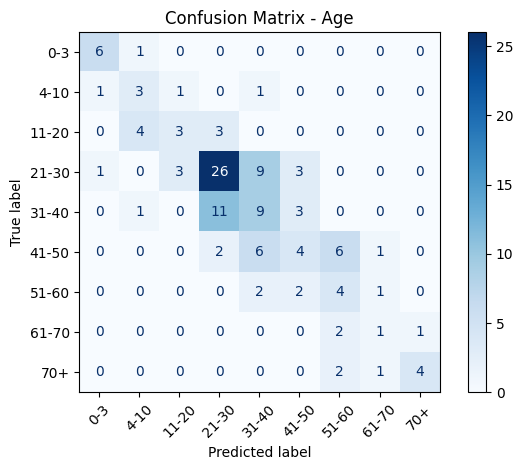

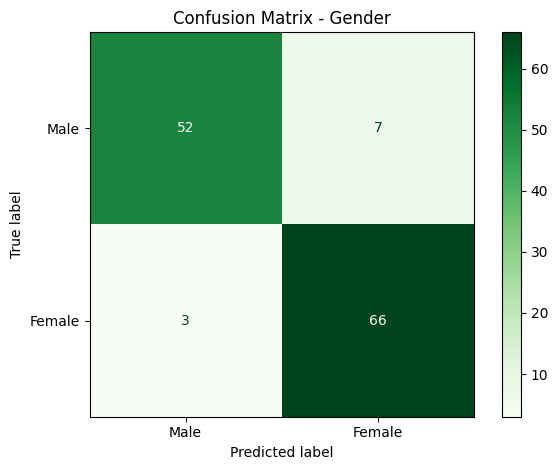

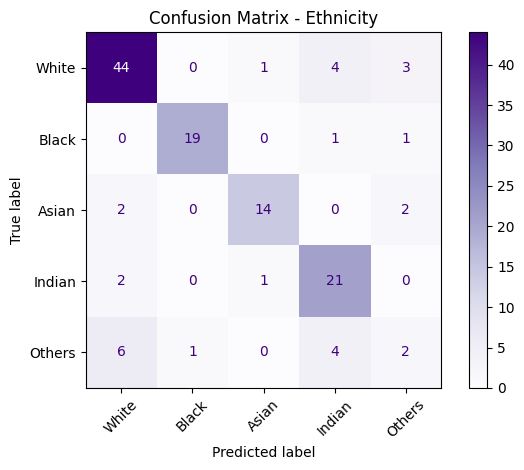

In [84]:
# Creating confusion matrix

true_age = age_labels.cpu().numpy()
pred_age = age_preds.cpu().numpy()

true_gender = gender_labels.cpu().numpy()
pred_gender = gender_preds.cpu().numpy()

true_ethnicity = ethnicity_labels.cpu().numpy()
pred_ethnicity = ethnicity_preds.cpu().numpy()

# Confusion matrix for age
cm_age = confusion_matrix(true_age, pred_age)
disp_age = ConfusionMatrixDisplay(confusion_matrix=cm_age, display_labels=class_names['age'])
disp_age.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Age")
plt.tight_layout()
plt.show()

# Confusion matrix for gender
cm_gender = confusion_matrix(true_gender, pred_gender)
disp_gender = ConfusionMatrixDisplay(confusion_matrix=cm_gender, display_labels=class_names['gender'])
disp_gender.plot(cmap='Greens')
plt.title("Confusion Matrix - Gender")
plt.tight_layout()
plt.show()

# Confusion matrix for ethnicity
cm_ethnicity = confusion_matrix(true_ethnicity, pred_ethnicity)
disp_ethnicity = ConfusionMatrixDisplay(confusion_matrix=cm_ethnicity, display_labels=class_names['ethnicity'])
disp_ethnicity.plot(cmap='Purples', xticks_rotation=45)
plt.title("Confusion Matrix - Ethnicity")
plt.tight_layout()
plt.show()
